In [1]:
import pandas as pd 

In [2]:
DATA = "/Users/ayemaq/Desktop/Marcy Projects/Mod6_Project/Data/Motor_Vehicle_Collisions_-_Crashes_20251209.csv"
BORO_SHAPE = "/Users/ayemaq/Desktop/Marcy Projects/Mod6_Project/Data/nybb/nybb.shp"

In [3]:
df = pd.read_csv(DATA)

In [4]:
df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,01/02/2022,9:20,NaN,NaN,NaN,NaN,NaN,VANDAM STREET,BORDEN AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4491517,Sedan,Box Truck,NaN,NaN,NaN
1,01/02/2022,12:50,QUEENS,11373.0,40.735065,-73.88184,"(40.735065, -73.88184)",GRAND AVENUE,VANKLEECK STREET,NaN,...,Unspecified,NaN,NaN,NaN,4492016,Sedan,Bike,NaN,NaN,NaN
2,01/02/2022,0:30,NaN,NaN,40.699190,-73.91469,"(40.69919, -73.91469)",IRVING AVENUE,NaN,NaN,...,NaN,NaN,NaN,NaN,4491657,Sedan,NaN,NaN,NaN,NaN
3,01/02/2022,8:44,BRONX,10460.0,40.842224,-73.88776,"(40.842224, -73.88776)",NaN,NaN,1902 MARMION AVENUE,...,Unspecified,NaN,NaN,NaN,4491839,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,01/02/2022,4:15,NaN,NaN,40.743210,-73.89608,"(40.74321, -73.89608)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,NaN,NaN,NaN,NaN,4491367,Sedan,NaN,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370560 entries, 0 to 370559
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH DATE                     370560 non-null  object 
 1   CRASH TIME                     370560 non-null  object 
 2   BOROUGH                        262849 non-null  object 
 3   ZIP CODE                       262797 non-null  float64
 4   LATITUDE                       346415 non-null  float64
 5   LONGITUDE                      346415 non-null  float64
 6   LOCATION                       346415 non-null  object 
 7   ON STREET NAME                 265324 non-null  object 
 8   CROSS STREET NAME              189540 non-null  object 
 9   OFF STREET NAME                105232 non-null  object 
 10  NUMBER OF PERSONS INJURED      370560 non-null  int64  
 11  NUMBER OF PERSONS KILLED       370560 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED 

In [6]:
# fix data types for date and time
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'], errors='coerce')
df['CRASH TIME'] = pd.to_datetime(df['CRASH TIME'], format='%H:%M', errors='coerce')

In [7]:
df['CRASH DATE'].dtype, df['CRASH TIME'].dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [8]:
df['hour'] = df['CRASH TIME'].dt.hour
df['month'] = df['CRASH DATE'].dt.month
df['day_of_week'] = df['CRASH DATE'].dt.dayofweek

#### a lil sanity check

In [9]:
df['hour'].isnull().sum(), df['month'].isnull().sum(), df['day_of_week'].isnull().sum()

(np.int64(0), np.int64(0), np.int64(0))

In [10]:
df['CRASH DATE'].isna().sum(), df['CRASH TIME'].isna().sum()


(np.int64(0), np.int64(0))

In [11]:
df.isnull().sum()   

CRASH DATE                            0
CRASH TIME                            0
BOROUGH                          107711
ZIP CODE                         107763
LATITUDE                          24145
LONGITUDE                         24145
LOCATION                          24145
ON STREET NAME                   105236
CROSS STREET NAME                181020
OFF STREET NAME                  265328
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      2501
CONTRIBUTING FACTOR VEHICLE 2     87758
CONTRIBUTING FACTOR VEHICLE 3    337084
CONTRIBUTING FACTOR VEHICLE 4    361756
CONTRIBUTING FACTOR VEHICLE 5    367927
COLLISION_ID                          0
VEHICLE TYPE CODE 1                5959


In [12]:
df['BOROUGH'].isnull().sum()

np.int64(107711)

In [13]:
df[['LATITUDE', 'LONGITUDE']].isnull().sum()

LATITUDE     24145
LONGITUDE    24145
dtype: int64

In [15]:
import geopandas as gpd
from shapely.geometry import Point

# drop rows missing coordinates
df = df.dropna(subset=["LATITUDE", "LONGITUDE"])

# convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["LONGITUDE"], df["LATITUDE"]),
    crs="EPSG:4326"
)

# load borough boundaries
boros = gpd.read_file(BORO_SHAPE)
boros = boros.to_crs("EPSG:4326")   # match coordinate system

# spatial join: assign each crash a borough based on its coordinates
gdf = gdf.sjoin(boros, how="left", predicate="within")

# look at borough nulls
print(gdf["BoroName"].isna().sum())

gdf.head()


5557


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,VEHICLE TYPE CODE 5,hour,month,day_of_week,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
1,2022-01-02,1900-01-01 12:50:00,QUEENS,11373.0,40.735065,-73.88184,"(40.735065, -73.88184)",GRAND AVENUE,VANKLEECK STREET,NaN,...,NaN,12,1,6,POINT (-73.88184 40.73506),2.0,4.0,Queens,887905.076135,3.041419e+09
2,2022-01-02,1900-01-01 00:30:00,NaN,NaN,40.699190,-73.91469,"(40.69919, -73.91469)",IRVING AVENUE,NaN,NaN,...,NaN,0,1,6,POINT (-73.91469 40.69919),4.0,3.0,Brooklyn,726953.045036,1.934463e+09
3,2022-01-02,1900-01-01 08:44:00,BRONX,10460.0,40.842224,-73.88776,"(40.842224, -73.88776)",NaN,NaN,1902 MARMION AVENUE,...,NaN,8,1,6,POINT (-73.88776 40.84222),1.0,2.0,Bronx,463147.071763,1.187199e+09
4,2022-01-02,1900-01-01 04:15:00,NaN,NaN,40.743210,-73.89608,"(40.74321, -73.89608)",BROOKLYN QUEENS EXPRESSWAY,NaN,NaN,...,NaN,4,1,6,POINT (-73.89608 40.74321),2.0,4.0,Queens,887905.076135,3.041419e+09
6,2022-01-02,1900-01-01 03:00:00,NaN,NaN,40.762940,-73.86067,"(40.76294, -73.86067)",GRAND CENTRAL PKWY,NaN,NaN,...,NaN,3,1,6,POINT (-73.86067 40.76294),2.0,4.0,Queens,887905.076135,3.041419e+09


In [16]:
df = gdf

### note to self
- The column gets filled **only** gets filled if the crash points lat/lon is inside NYC
- So technically if `BoroName` is NA then that means the crash coordinate isn't inside NYC polygon. Could be because:
    - The coordinate is invalid
    - Coordinate is somewhere outside NYC (like jersey)
- So basically a missing `BoroName` just means the row is not a valid NYC crash based on location
- I'll go into this later

In [17]:
df[['LATITUDE', 'LONGITUDE']].isnull().sum()

LATITUDE     0
LONGITUDE    0
dtype: int64

In [18]:
df.isnull().sum()

CRASH DATE                            0
CRASH TIME                            0
BOROUGH                           87948
ZIP CODE                          87993
LATITUDE                              0
LONGITUDE                             0
LOCATION                              0
ON STREET NAME                   102716
CROSS STREET NAME                167138
OFF STREET NAME                  243699
NUMBER OF PERSONS INJURED             0
NUMBER OF PERSONS KILLED              0
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1      2412
CONTRIBUTING FACTOR VEHICLE 2     82573
CONTRIBUTING FACTOR VEHICLE 3    315566
CONTRIBUTING FACTOR VEHICLE 4    338254
CONTRIBUTING FACTOR VEHICLE 5    343951
COLLISION_ID                          0
VEHICLE TYPE CODE 1                5719


## Documentation of my work so far before continuing 
- I converted raw strings to proper datetime formats for later feature engineering, this enables extraction of hour, month, and day-of-week later.
- Cleaned the coordinate data 
    - Used official NYC borough boundary shapefile to fill NAs for coordinates and the BOROUGH column (now `BoroName`)
    - Result: ~5,557 null boroughs
    - Much fewer than the original 100k+.
- Decision: Do Not Use Original BOROUGH or ZIP CODE... Based on quality issues:
    - Original BOROUGH column will not be used
        - (too many missing values; inconsistent)
    - ZIP CODE will not be used
        - (uninformative for modeling, high missingness, unreliable)

In [19]:
df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts()

CONTRIBUTING FACTOR VEHICLE 1
Driver Inattention/Distraction                           86066
Unspecified                                              85719
Failure to Yield Right-of-Way                            24302
Following Too Closely                                    19426
Passing or Lane Usage Improper                           14645
Unsafe Speed                                             12378
Passing Too Closely                                      12159
Backing Unsafely                                         10787
Other Vehicular                                          10714
Traffic Control Disregarded                               9816
Turning Improperly                                        8209
Driver Inexperience                                       7356
Unsafe Lane Changing                                      6492
Alcohol Involvement                                       6452
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     4014
Reaction to Uninvolved Ve

In [20]:
df.keys()

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'hour', 'month', 'day_of_week', 'geometry', 'index_right', 'BoroCode',
       'BoroName', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

## Next handle cleaning Vehicle type code 1

In [21]:
df['Type code 1'] = df['VEHICLE TYPE CODE 1'].value_counts()

In [22]:
df['VEHICLE TYPE CODE 1'].unique()

array(['Sedan', 'Ambulance', 'Station Wagon/Sport Utility Vehicle',
       'Pick-up Truck', 'Garbage or Refuse', nan, 'Tanker', 'PK',
       'E-Bike', 'AMBULANCE', 'E-Scooter', 'Motorcycle', 'Bike', 'Taxi',
       'Box Truck', 'Bus', 'Dump', 'Flat Bed', '3-Door', 'Carry All',
       'Convertible', 'Pedicab', 'Tractor Truck Diesel', 'Van',
       'Tractor Truck Gasoline', 'MOTOR SCOO', 'Moped', '4 dr sedan',
       'Firetruck', 'SELF', 'Snow Plow', 'TRAILER', 'Tow Truck / Wrecker',
       'Refrigerated Van', 'Motorbike', 'FIRE TRUCK', 'Motorscooter',
       'School Bus', 'passenger', 'UTILITY', 'Minibike', 'Lunch Wagon',
       'FIRETRUCK', 'Forklift', 'LIMO', 'Stake or Rack', 'Motorized Home',
       'DELV', 'Tow Truck', 'Beverage Truck', 'Flat Rack',
       'Concrete Mixer', 'Chassis Cab', 'Bulk Agriculture', 'unk', 'tr',
       'Fire truck', 'Truck', 'M2', 'Armored Truck', 'Pas (4dr s', 'Ambu',
       'moped', 'Delivery', 'Backhoe', 'PICK UP TR', 'Passenger',
       'USPS small', 'FD

In [23]:
df['Type code 1 lower'] = df['VEHICLE TYPE CODE 1'].str.lower()

In [24]:
counts = df['Type code 1 lower'].value_counts()

In [25]:
df['count vehicles'] = df['Type code 1 lower'].map(counts)

In [26]:
df[['VEHICLE TYPE CODE 1', 'Type code 1 lower', 'count vehicles']]

,VEHICLE TYPE CODE 1,Type code 1 lower,count vehicles
1,Sedan,sedan,158471.0
2,Sedan,sedan,158471.0
3,Sedan,sedan,158471.0
4,Sedan,sedan,158471.0
6,Ambulance,ambulance,2321.0
...,...,...,...
370554,Sedan,sedan,158471.0
370555,Station Wagon/Sport Utility Vehicle,station wagon/sport utility vehicle,119145.0
370557,Sedan,sedan,158471.0
370558,Bus,bus,6603.0


In [27]:
df['count vehicles'].describe()

count    340696.000000
mean     116312.915784
std       55886.006203
min           1.000000
25%      119145.000000
50%      119145.000000
75%      158471.000000
max      158471.000000
Name: count vehicles, dtype: float64

In [28]:
df['veh_type'] = df['VEHICLE TYPE CODE 1'].str.lower().str.strip()

In [29]:
# look at the most common 
df['veh_type'].value_counts().head(25)

veh_type
sedan                                  158471
station wagon/sport utility vehicle    119145
taxi                                     9636
pick-up truck                            7921
bus                                      6603
bike                                     6379
box truck                                5535
motorcycle                               3416
e-bike                                   2843
moped                                    2452
ambulance                                2321
tractor truck diesel                     2287
van                                      2088
e-scooter                                1690
dump                                     1112
convertible                               862
pk                                        860
garbage or refuse                         775
flat bed                                  566
carry all                                 404
tow truck / wrecker                       403
tractor truck gasoline   

In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

df['veh_type'].unique()


array(['sedan', 'ambulance', 'station wagon/sport utility vehicle',
       'pick-up truck', 'garbage or refuse', nan, 'tanker', 'pk',
       'e-bike', 'e-scooter', 'motorcycle', 'bike', 'taxi', 'box truck',
       'bus', 'dump', 'flat bed', '3-door', 'carry all', 'convertible',
       'pedicab', 'tractor truck diesel', 'van', 'tractor truck gasoline',
       'motor scoo', 'moped', '4 dr sedan', 'firetruck', 'self',
       'snow plow', 'trailer', 'tow truck / wrecker', 'refrigerated van',
       'motorbike', 'fire truck', 'motorscooter', 'school bus',
       'passenger', 'utility', 'minibike', 'lunch wagon', 'forklift',
       'limo', 'stake or rack', 'motorized home', 'delv', 'tow truck',
       'beverage truck', 'flat rack', 'concrete mixer', 'chassis cab',
       'bulk agriculture', 'unk', 'tr', 'truck', 'm2', 'armored truck',
       'pas (4dr s', 'ambu', 'delivery', 'backhoe', 'pick up tr',
       'usps small', 'fdny ambul', 'suv', '2 dr sedan', '100th truc',
       'food cart', 'ap

##### Note to self
- I clicked open in a text editor and what in the world.. 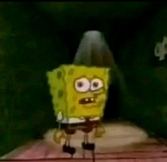

In [31]:
def categorize_vehicle(x):
    if pd.isna(x):
        return 'other'
    
    if 'sedan' in x:
        return 'sedan'
    if 'suv' in x or 'station wagon' in x:
        return 'suv'
    if 'taxi' in x or 'cab' in x:
        return 'taxi'
    if 'bus' in x:
        return 'bus'
    if 'bike' in x or 'bicycle' in x:
        return 'bike'
    if 'motor' in x or 'moped' in x or 'scooter' in x or 'cycle' in x:
        return 'motorcycle'
    if 'van' in x:
        return 'van'
    if ('truck' in x or 'trk' in x or 'pick' in x or 'flatbed' in x 
        or 'box truck' in x or 'tractor' in x or 'dump' in x):
        return 'truck'
    
    return 'other'


In [32]:
df['veh_group'] = df['veh_type'].apply(categorize_vehicle)

In [33]:
df['veh_group'].value_counts()


veh_group
sedan         158566
suv           119157
truck          18223
other          14133
taxi            9957
bike            9458
motorcycle      7991
bus             6737
van             2193
Name: count, dtype: int64

## docoumentation for cleaning Vehicle type 1 column
### The reasoning
- The raw VEHICLE TYPE CODE 1 column contained over 800 unique values, including:
    - typos
    - abbreviations
    - agency vehicle types (FDNY, USPS, MTA, NYPD)
    - equipment (forklifts, bulldozers, cranes)
    - extremely specific truck types
    - scooters, mopeds, dirt bikes, bikes
    - garbage trucks, delivery vans
    - and many inconsistent variations (“pick-up truck”, “pick up tr”, “pickup”, “pick-up f-”, etc.)
- This level of granularity is not useful for modeling pedestrian injury risk and is not interpretable for Vision Zero stakeholders.
- Therefore, we generalized all vehicle types into meaningful, safety-focused groups.

##### Steps 
- First we converted vehicle type strings to lowercase and stripped whitespace and this reduced variation caused by casing and spacing but did not fix inconsistencies which is expected.
- Next we inspected the full list of unique entries... This confirmed that the raw data included:
    - duplicate categories with minor spelling differences
    - dozens of truck variations
    - multiple scooter/moped/motorcycle forms
    - unusual entries (e.g., “horse draw”, “lawn mower”, “house on w”)
    - many agency-specific vehicles
    - several “unknown” types
        - This justified the need for categorical generalization.
- When I looked at this column, there were literally 800+ random vehicle types. Half of them were typos, super specific versions of the same thing, or agency vehicles like FDNY ladders, USPS vans, forklifts, etc. There’s no way this level of detail is useful for modeling or for Vision Zero, and trying to clean every single one would just make things messy, it would introduce noise and it's time consuming. So instead, I grouped everything into broad categories that actually matter for pedestrian safety, like sedan, SUV, truck, taxi, bike, motorcycle, van, and bus. These categories show the real differences in risk, and they keep the model easy to interpret. The point isn’t to perfectly fix every label, it’s to make the data meaningful, clean, and something a stakeholder can actually use. So generalizing was the smartest and cleanest way to handle this column.

### Further cleaning regarding lat and lon

In [34]:
boros.total_bounds # GeoPandas function that tells you the exact geographic bounding box of your shapefile... epic

array([-74.25559136,  40.49613399, -73.70000906,  40.91553278])

In [35]:
# check for invalid or outside nyc coordinates
invalid_lat = (df['LATITUDE'] < 40) | (df['LATITUDE'] > 41)
invalid_lon = (df['LONGITUDE'] < -74.3) | (df['LONGITUDE'] > -73.3)

invalid_total = df[invalid_lat | invalid_lon]

len(invalid_total)


4479

In [36]:
df[invalid_lon].shape[0]

4479

In [37]:
df[invalid_lat].shape[0]


4479

In [38]:
gdf = gdf[(gdf['LATITUDE'] > 35) & (gdf['LATITUDE'] < 46)]
gdf = gdf[(gdf['LONGITUDE'] < -70) & (gdf['LONGITUDE'] > -80)]


In [39]:
df.keys()

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'hour', 'month', 'day_of_week', 'geometry', 'index_right', 'BoroCode',
       'BoroName', 'Shape_Leng', 'Shape_Area', 'Type code 1',
       'Type code 1 lower', 'count vehicles', 'veh_type', 'veh_group'],
      dtype='object')

In [40]:
gdf[['LATITUDE', 'LONGITUDE', 'BoroName']].head()

,LATITUDE,LONGITUDE,BoroName
1,40.735065,-73.88184,Queens
2,40.699190,-73.91469,Brooklyn
3,40.842224,-73.88776,Bronx
4,40.743210,-73.89608,Queens
6,40.762940,-73.86067,Queens


In [41]:
missing_boros = gdf[gdf['BoroName'].isnull()]
missing_boros.shape

(1078, 43)

<Axes: >

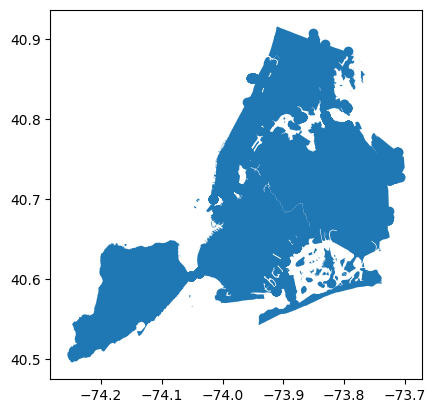

In [42]:
points_near_boundry = missing_boros.plot()
boros.plot(ax=points_near_boundry)

<Axes: >

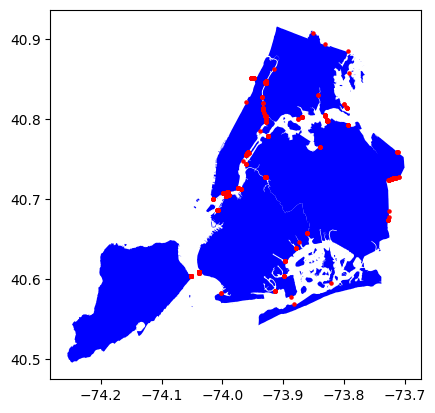

In [43]:
base = boros.plot(color = 'blue')
missing_boros.plot(ax=base, marker='o', color='red', markersize=5)


In [44]:
missing_boros[['LATITUDE', 'LONGITUDE', 'BoroName']].head()

,LATITUDE,LONGITUDE,BoroName
286,40.622414,-73.896484,NaN
2348,40.797737,-73.826990,NaN
2932,40.727870,-73.929130,NaN
3239,40.845352,-73.928210,NaN
3276,40.758340,-73.957750,NaN


### yap documentation... in simple terms
- What is a polygon? 
     - it's a shape drawn on a map, it covers an area with edges and corners
        - Like the outline of manhattan, brooklyn, queens and so on
        - So saying "brooklyn polygon" refers to the official drawn shape that represents Brooklyn on the map
- In this context, a point refers to a location in NYC with a single lat and long 
    - So the points represent where the crash happened and it's exact spot
- The question is why do some points get a borough, whilst others get NaN?
    - if the point is inside a polygon -> it gets a borough name
    - if the point is outside all polygons -> it'll get an NaN
        - This includes points in water (also known as water polygon), points on bridges, points exactly on boundry lines

- I can drop these NaN's because borderline points add noise, not insight 

In [45]:
gdf = gdf[gdf['BoroName'].notna()]

In [46]:
# sanity check for na's in boroughs
gdf['BoroName'].isna().sum()

np.int64(0)

### lets clean up aile 5... aka the outliers
- I think these are important findings, these extreme cases can reveal systemic risks or dangerous intersections, speeding corridors or maybe a lighting or road design issues
- the presence of VEHICLE TYPE CODE 5 (5 vehicles) explains the high injury counts. These rows are NOT errors and should NOT be dropped. They represent serious crashes and are extremely valuable to your analysis.

In [47]:
df.keys()

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'hour', 'month', 'day_of_week', 'geometry', 'index_right', 'BoroCode',
       'BoroName', 'Shape_Leng', 'Shape_Area', 'Type code 1',
       'Type code 1 lower', 'count vehicles', 'veh_type', 'veh_group'],
      dtype='object')

In [48]:
df[['NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED']].describe()

,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED
count,346415.000000,346415.000000,346415.000000,346415.000000,346415.000000,346415.000000,346415.000000,346415.000000
mean,0.552811,0.002685,0.099525,0.001250,0.056092,0.000254,0.375218,0.001039
std,0.838572,0.054303,0.316867,0.036458,0.234264,0.015936,0.814789,0.034804
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,34.000000,4.000000,19.000000,4.000000,3.000000,1.000000,34.000000,3.000000


In [49]:
df[df['NUMBER OF PERSONS INJURED'] > 30]

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area,Type code 1,Type code 1 lower,count vehicles,veh_type,veh_group
127763,2023-04-07,1900-01-01 22:24:00,QUEENS,11361.0,40.75958,-73.76894,"(40.75958, -73.76894)",BELL BOULEVARD,45 ROAD,NaN,...,2.0,4.0,Queens,887905.076135,3.041419e+09,NaN,bus,6603.0,bus,bus


In [ ]:
# df[(df['NUMBER OF PERSONS INJURED'] > 30) & (df['NUMBER OF PERSONS INJURED'] < 40)]

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area,Type code 1,Type code 1 lower,count vehicles,veh_type,veh_group
127763,2023-04-07,1900-01-01 22:24:00,QUEENS,11361.0,40.75958,-73.76894,"(40.75958, -73.76894)",BELL BOULEVARD,45 ROAD,NaN,...,2.0,4.0,Queens,887905.076135,3.041419e+09,NaN,bus,6603.0,bus,bus


In [57]:
# df[(df['NUMBER OF PERSONS INJURED'] > 10) & (df['NUMBER OF PERSONS INJURED'] < 20)]

In [51]:
vehicle_cols = [
    'VEHICLE TYPE CODE 1',
    'VEHICLE TYPE CODE 2',
    'VEHICLE TYPE CODE 3',
    'VEHICLE TYPE CODE 4',
    'VEHICLE TYPE CODE 5'
]

df['num_vehicles'] = df[vehicle_cols].notna().sum(axis=1)
df['num_vehicles'].value_counts()

num_vehicles
2    199665
1    112401
3     20912
0      5718
4      5357
5      2362
Name: count, dtype: int64

In [52]:
'veh_type' in df.columns


True

In [53]:
gdf['veh_type'] = df['veh_type']
gdf['num_vehicles'] = df['num_vehicles']

In [54]:
df[df['NUMBER OF PERSONS INJURED'] > 10][[
    'NUMBER OF PERSONS INJURED',
    'num_vehicles',
    'veh_type'
]]

,NUMBER OF PERSONS INJURED,num_vehicles,veh_type
16842,13,3,bus
37848,13,2,station wagon/sport utility vehicle
40815,15,2,bus
54634,14,2,box truck
61289,13,1,bus
67414,15,2,bus
87229,11,3,bus
88062,11,2,bus
104063,21,1,station wagon/sport utility vehicle
119439,11,2,bus


### note
During cleaning, we examined rows where more than 10 people were injured. Most of these involved buses, trucks, or SUVs, which is realistic because these vehicles carry many passengers. The number of vehicles involved was consistent with the severity of the crash, so we kept these rows instead of treating them as outliers.

In [56]:
df[df['NUMBER OF PERSONS INJURED'] > 10].groupby('veh_type').size().sort_values(ascending=False)


veh_type
bus                                    24
station wagon/sport utility vehicle    11
sedan                                   5
box truck                               3
taxi                                    2
van                                     2
ambulance                               1
carry all                               1
garbage or refuse                       1
limo                                    1
pick-up truck                           1
dtype: int64

In [58]:
df['NUMBER OF PEDESTRIANS INJURED'].describe()

count    346415.000000
mean          0.099525
std           0.316867
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: NUMBER OF PEDESTRIANS INJURED, dtype: float64

In [60]:
df[df['NUMBER OF PEDESTRIANS INJURED'] > 5]

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,BoroCode,BoroName,Shape_Leng,Shape_Area,Type code 1,Type code 1 lower,count vehicles,veh_type,veh_group,num_vehicles
104063,2023-01-02,1900-01-01 20:59:00,NaN,NaN,40.867012,-73.92312,"(40.867012, -73.92312)",BROADWAY,NaN,NaN,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,station wagon/sport utility vehicle,119145.0,station wagon/sport utility vehicle,suv,1
159410,2023-08-01,1900-01-01 17:35:00,MANHATTAN,10168.0,40.751442,-73.97606,"(40.751442, -73.97606)",LEXINGTON AVENUE,EAST 42 STREET,NaN,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,taxi,9636.0,taxi,taxi,4
164818,2023-08-21,1900-01-01 02:00:00,MANHATTAN,10018.0,40.751080,-73.98686,"(40.75108, -73.98686)",AVENUE OF THE AMERICAS,WEST 36 STREET,NaN,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,sedan,158471.0,sedan,sedan,1
246692,2024-07-04,1900-01-01 20:52:00,MANHATTAN,10002.0,40.711533,-73.98063,"(40.711533, -73.98063)",WATER STREET,JACKSON STREET,NaN,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,pick-up truck,7921.0,pick-up truck,truck,1
290041,2024-12-25,1900-01-01 16:00:00,MANHATTAN,10001.0,40.749790,-73.98777,"(40.74979, -73.98777)",W 34 ST,AVENUE OF THE AMERICAS,NaN,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,taxi,9636.0,taxi,taxi,1
333531,2025-07-03,1900-01-01 10:50:00,BRONX,10451.0,40.816555,-73.91954,"(40.816555, -73.91954)",E 149 ST,COURTLANDT AVE,NaN,...,2.0,Bronx,463147.071763,1.187199e+09,NaN,sedan,158471.0,sedan,sedan,1
359475,2025-10-20,1900-01-01 15:55:00,MANHATTAN,10001.0,40.749363,-73.99530,"(40.749363, -73.9953)",NaN,NaN,400 8 AVE,...,1.0,Manhattan,359536.412002,6.366312e+08,NaN,van,2088.0,van,van,2


In [62]:
#  check total number of pedestrian injuries
df['NUMBER OF PEDESTRIANS INJURED'].sum()


np.int64(34477)

In [63]:
df[(df['NUMBER OF PEDESTRIANS INJURED'] >= 1) &
   (df['NUMBER OF PEDESTRIANS INJURED'] <= 5)].shape[0]


33045

In [64]:
df['NUMBER OF PEDESTRIANS INJURED'].value_counts().sort_index()


NUMBER OF PEDESTRIANS INJURED
0     313363
1      31830
2       1091
3        100
4         17
5          7
6          1
7          3
8          2
19         1
Name: count, dtype: int64

(Important: one crash can injure multiple pedestrians, so this sum is NOT the number of crashes.)

313,363 crashes had 0 pedestrians injured

31,380 crashes had 1 pedestrian injured

1,901 crashes had 2 pedestrians injured

High-injury crashes (3, 4, 5, etc.) are rare and expected to be outliers

In [70]:
df[df['NUMBER OF PEDESTRIANS INJURED'] > 5][[
    'NUMBER OF PEDESTRIANS INJURED',
    'num_vehicles',
    'veh_type'
]]

,NUMBER OF PEDESTRIANS INJURED,num_vehicles,veh_type
104063,19,1,station wagon/sport utility vehicle
159410,8,4,taxi
164818,7,1,sedan
246692,7,1,pick-up truck
290041,7,1,taxi
333531,6,1,sedan
359475,8,2,van


In [ ]:
# now lets do pedestrian killed by vehicle type
df['NUMBER OF PEDESTRIANS KILLED'].describe()


count    346415.000000
mean          0.001250
std           0.036458
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: NUMBER OF PEDESTRIANS KILLED, dtype: float64

In [73]:
# Count how many crashes had 0, 1, 2, etc. pedestrian fatalities
df['NUMBER OF PEDESTRIANS KILLED'].value_counts().sort_index()

NUMBER OF PEDESTRIANS KILLED
0    345992
1       416
2         5
3         1
4         1
Name: count, dtype: int64

In [77]:
# show crashes only where pedestrians were killed
# df[df['NUMBER OF PEDESTRIANS KILLED'] > 0][[
#     'NUMBER OF PEDESTRIANS KILLED',
#     'NUMBER OF PERSONS INJURED',
#     'NUMBER OF PERSONS KILLED',
#     'num_vehicles',
#     'veh_type'
# ]]


In [78]:
df[df['NUMBER OF PEDESTRIANS KILLED'] > 3]


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,BoroName,Shape_Leng,Shape_Area,Type code 1,Type code 1 lower,count vehicles,veh_type,veh_group,num_vehicles,NUMBER OF PEDESTRIANS_INJURED_TOTAL
246692,2024-07-04,1900-01-01 20:52:00,MANHATTAN,10002.0,40.711533,-73.98063,"(40.711533, -73.98063)",WATER STREET,JACKSON STREET,NaN,...,Manhattan,359536.412002,6.366312e+08,NaN,pick-up truck,7921.0,pick-up truck,truck,1,34477


Fatal pedestrian crashes are extremely rare (416 crashes where exactly one pedestrian died and 21 crashes where multiple pedestrians died (2, 3, or 4 deaths)). Vehicles involved in these events are often larger types such as trucks, vans, or SUVs, which aligns with higher risk due to vehicle mass and impact force.

In [80]:
df.shape, gdf.shape


((346415, 45), (340858, 44))

In [82]:
df = gdf.copy()

In [83]:
# save cleaned data
df = gdf.drop(columns=['geometry'])
df.to_csv("/Users/ayemaq/Desktop/Marcy Projects/Mod6_Project/Data/cleaned_crash_data.csv", index=False)
